# Generates a flow (demand) file
#### Either fully random or it is possible to determine some main roads and side roads and generate different demand levels on them

In [1]:
from read_roadmap import read_roadmap
from write_json import write_json_flow_file
from plot_histogram import plot_distribution

from collections import Counter
import numpy as np

In [2]:
A1 = {i: [f"road_0_{i}_0", f"road_30_{i}_0"] for i in range(9,12)}
A2 = {i: [f"road_31_{i}_2", f"road_1_{i}_2"] for i in range(9,12)}
A3 = {i: [f"road_0_{i}_0", f"road_30_{i}_0"] for i in range(1,7)}
A4 = {i: [f"road_31_{i}_2", f"road_1_{i}_2"] for i in range(1,7)}

D = {i: [f"road_0_{i}_0", f"road_1_{i}_2"] for i in range(7,9)}

B1 = {i: [f"road_{i}_12_3", f"road_{i}_1_3"] for i in range(1, 11)}
B2 = {i: [f"road_{i}_0_1", f"road_{i}_11_1"] for i in range(1, 11)}
C1 = {i: [f"road_{i}_12_3", f"road_{i}_1_3"] for i in range(11, 31)}
C2 = {i: [f"road_{i}_0_1", f"road_{i}_11_1"] for i in range(11, 31)}

all_main_roads = {"A1": A1, "A2": A2, "A3": A3, "A4": A4, "D": D, "B1": B1, "B2": B2, "C1": C1, "C2": C2}

# mapping: if we want all exits from A1 -> A2, we need to look at the values of dictionary A1 --> mapping["A2"]
mapping = {"A1": "A2", "A2": "A1", "A3": "A4", "A4": "A3", "D": "D", "B1": "B2", "B2": "B1", "C1": "C2", "C2": "C1"}

In [3]:
def main(subdirect, random_routes, random_vehicle_parameters):
    
    Road_map_Json = f"../Simulation_Results/{subdirect}/roadnet.json"
    Dir_FlowFile_Json = f"../Simulation_Results/{subdirect}/"
    FlowFile_Json = "flow.json"
    
    # if we want inflow / outflow from specific lanes, we can just overwrite roads_IN and roads_OUT
    roads_IN, roads_OUT, road_adj_to_IN, roads_INSIDE = read_roadmap(Road_map_Json)
    
    # "Fixed" or random vehicle routes (e.g. main and side roads)
    # ratio: what percentage [0,1] of all possible inflow-outflow combinations will have vehicles
    # effective_interval: what is the effective interval between 2 vehicles on a road (even with multiple routes starting from the same road)
    if random_routes:
        # what percentage [0,1] of all possible inflow and outflow combinations will be considered
        parameters = {
            "traffic_ratio_out": 0.7,
            "traffic_ratio_in": 0.002,
            "interval": 70.0
        }
        
    else:
        # Proportions
        proportions = {
            # Combination: [Percentage # vehicles [0,100], Percentage # possible routes] [0,1]
            "A1_A2": [0.1, 1],
            "A1_B1": [0.05, 1],
            "A1_C1": [0.1, 1],
            "A2_B1": [0.05, 1],
            "A2_C1": [0.1, 1],
            
            "A3_A4": [0.1, 1],
            "A3_B2": [0.05, 1],
            "A3_C2": [0.1, 1],
            "A4_B2": [0.05, 1],
            "A4_C2": [0.1, 1],
            
            "A1_A4": [0.01, 1],
            "A2_A3": [0.01, 1],
            "B1_A3": [0.01, 0.5],
            "B1_A4": [0.01, 0.5],
            "C1_A3": [0.02, 0.5],
            "C1_A4": [0.02, 0.5],
            "B2_A1": [0.01, 1],
            "B2_A2": [0.01, 1],
            "C2_A1": [0.02, 1],
            "C2_A2": [0.02, 1],
            
            "D_B1": [0.01, 1],
            "D_B2": [0.01, 1],
            "D_C1": [0.02, 1],
            "D_C2": [0.02, 1]
        }
        
        assert round(sum(val[0] for val in proportions.values()), 6) == 1, f"The percentages, should add up to 1, currently the sum is {round(sum(val[0] for val in proportions.values()), 6)}"
        
        # just used to determine side roads
        main_roads = set(element for sublist in list(all_main_roads.values()) for element in sublist)
        
        parameters = {
            # store all road names
            "all_main_roads": all_main_roads,
            "mapping": mapping,
            "proportions": proportions,
            
            # in the current case, there are no side roads as all roads are in a "main" category
            # keep here for consistency
            "side_roads": roads_IN.union(roads_OUT).difference(main_roads),
            
            # total demand for entire duration
            "total_demand": 4000,
            
            # all demand generation parameters
            # ratio: which percentage of possible combinations do we take (= Percentage # possible routes)
            "mtm": {"ratio": 0, "effective_interval": 50},
            "mts": {"ratio": 0, "effective_interval": 45},
            "sts": {"ratio": 0, "effective_interval": 45},    # effective interval only works if start time = 0
            "stm": {"ratio": 0, "effective_interval": 40},
            "iti": {"ratio": 0, "effective_interval": 40},
            "horizontal": {"ratio": 0, "effective_interval": 45}
        }
        
    
    # Fixed or random vehicle parameters
    if random_vehicle_parameters:
        write_json_flow_file(
            vehLen =  5,
            vehWidth =  2,
            roads_IN = roads_IN,
            roads_OUT = roads_OUT,
            road_adj_to_IN = road_adj_to_IN,
            parameters = parameters,
            directory = Dir_FlowFile_Json,
            FlowFile = FlowFile_Json,
            random_routes = random_routes,
            random_vehicle_parameters = random_vehicle_parameters
        )
        
    else:
        routes_dict, num_vehicles = write_json_flow_file(
            vehLen =  5.0,
            vehWidth =  2.0,
            vehMaxPosAcc = 3.0,
            vehMaxNegAcc = 4.5,
            vehUsualPosAcc = 2.0,
            vehUsualNegAcc = 3.5,
            vehMinGap = 2.5, # 2.5
            vehMaxSpeed =  8.333, # 14 m/s ~ 50 km/h
            vehHeadwayTime = 10,
            parameters = parameters,
            roads_IN = roads_IN,
            roads_OUT = roads_OUT,
            road_adj_to_IN = road_adj_to_IN,
            roads_INSIDE = roads_INSIDE,
            directory = Dir_FlowFile_Json,
            FlowFile = FlowFile_Json,
            random_routes = random_routes,
            random_vehicle_parameters = random_vehicle_parameters
        )
    
        # Plot distribution of generated vehicles
        total_frequencies, total_bins = plot_distribution(routes_dict, num_vehicles)
        
        
        return total_frequencies, total_bins

{'A1_A2': '0/9', 'A1_B1': '0/30', 'A1_C1': '0/60', 'A2_B1': '0/30', 'A2_C1': '0/60', 'A3_A4': '0/36', 'A3_B2': '0/60', 'A3_C2': '0/120', 'A4_B2': '0/60', 'A4_C2': '0/120', 'A1_A4': '18/18', 'A2_A3': '18/18', 'B1_A3': '30/30', 'B1_A4': '30/30', 'C1_A3': '60/60', 'C1_A4': '60/60', 'B2_A1': '30/30', 'B2_A2': '30/30', 'C2_A1': '60/60', 'C2_A2': '60/60', 'D_B1': '0/20', 'D_B2': '0/20', 'D_C1': '0/40', 'D_C2': '0/40', 'mts': '0/0', 'sts': '0/0', 'stm': '0/0', 'iti': '0/0', 'horizontal': '0/0'}
Number of routes generated (does not give all information about number of cars generated (different intervals))
A1_A2: 9
A1_B1: 30
A1_C1: 60
A2_B1: 30
A2_C1: 60
A3_A4: 36
A3_B2: 60
A3_C2: 120
A4_B2: 60
A4_C2: 120
A1_A4: 18
A2_A3: 18
B1_A3: 30
B1_A4: 30
C1_A3: 60
C1_A4: 60
B2_A1: 30
B2_A2: 30
C2_A1: 60
C2_A2: 60
D_B1: 20
D_B2: 20
D_C1: 40
D_C2: 40
mts: 0
sts: 0
stm: 0
iti: 0
horizontal: 0
Total flows: 1101
category: A1_A2, num cars: 400.0
interval, category: A1_A2, interval: 84.49, cars per route: 44.44

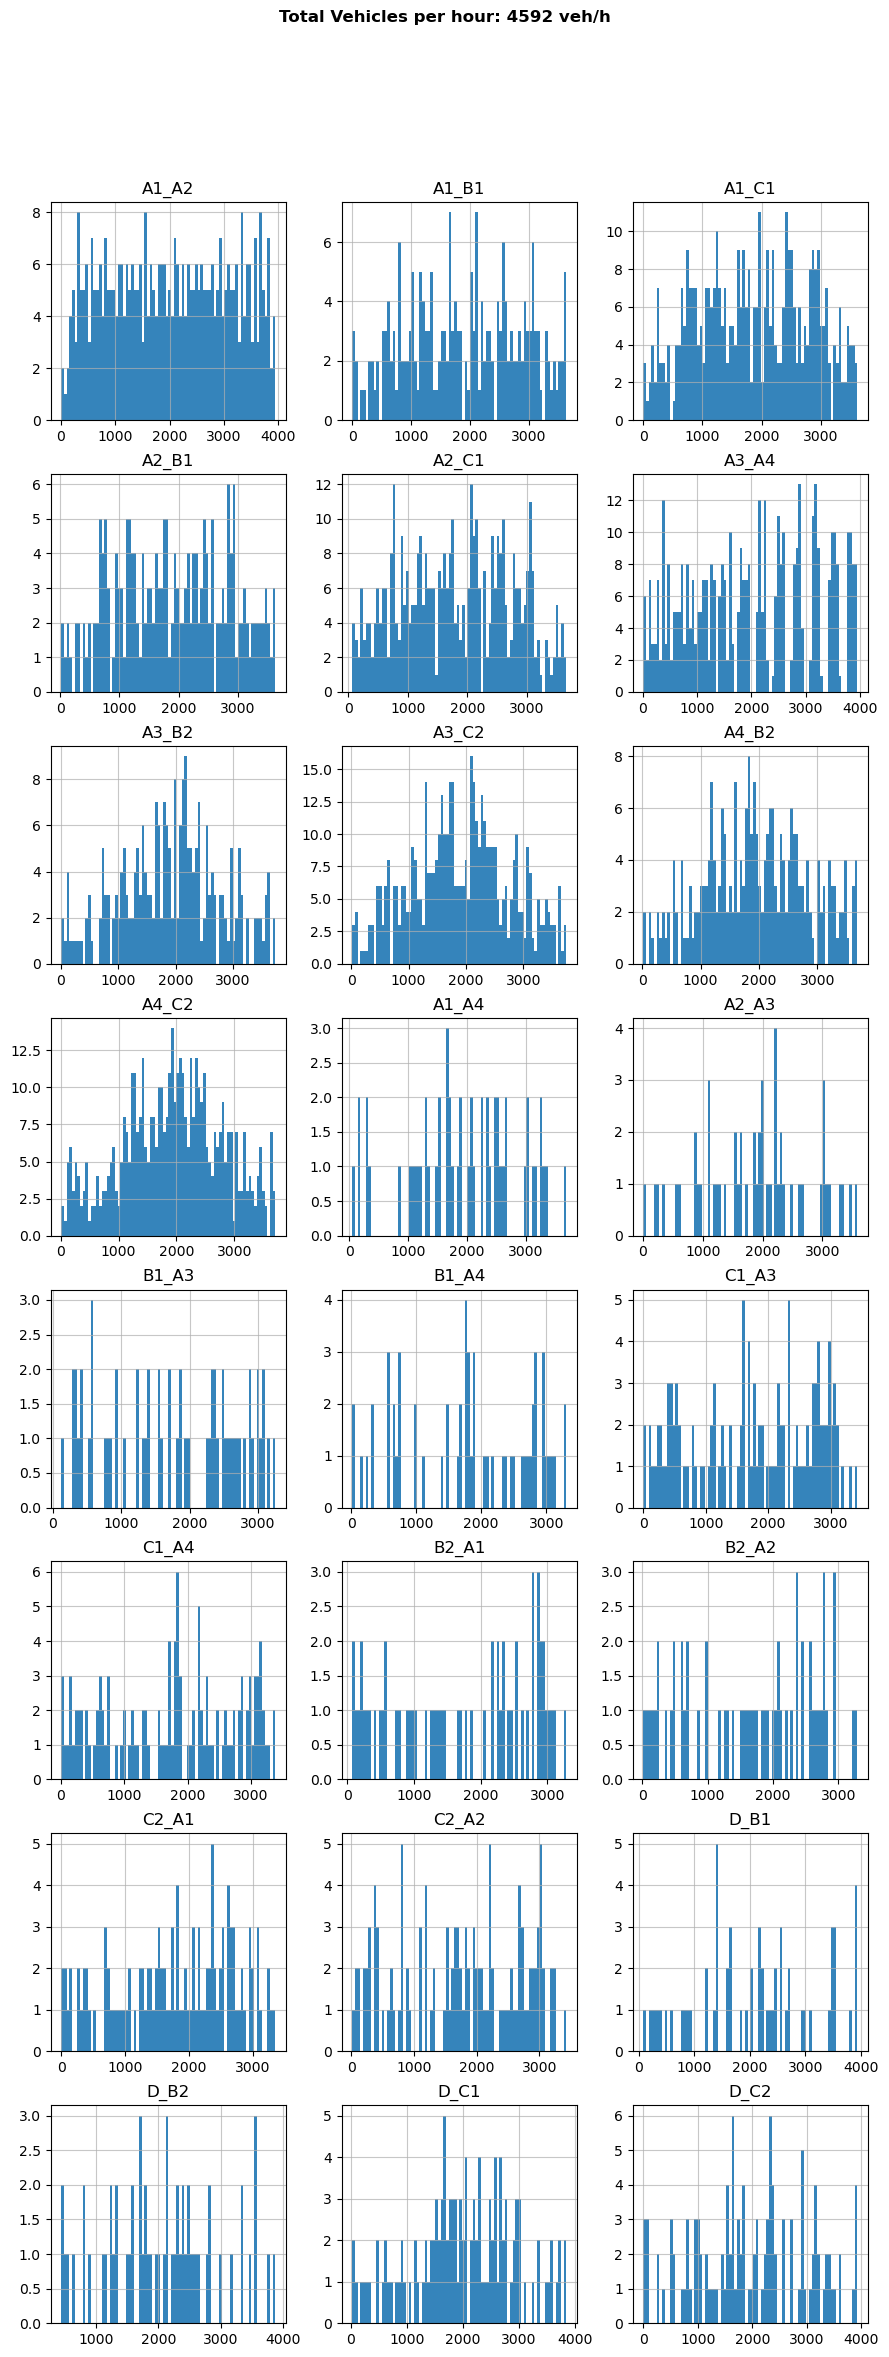

In [4]:
if __name__ == "__main__":
    
    # random vehicle routes
    random_routes = False
    
    # random vehicle parameters
    random_vehicle_parameters = False
    
    # sub directory of the roadnet file
    subdirect = "Manhattan"
    
    total_frequencies, total_bins = main(subdirect, random_routes, random_vehicle_parameters)

In [5]:
# Get the values from the dictionary
arrays = list(total_frequencies.values())

# Use zip to iterate over the corresponding elements
result = np.sum(list(zip(*arrays)), axis=1)

pair_sums = np.array([int(sum(result[i:i+2])) for i in range(0, len(result), 2)])

pair_sums

array([ 81,  78,  82,  86,  87,  78,  89, 110, 119, 103,  98, 121, 125,
       144, 127, 128, 137, 133, 182, 150, 125, 166, 179, 151, 146, 152,
       136, 135, 137, 108, 108, 132, 134, 117,  97, 103,  90,  73,  83,
        95])